<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Seismic_act_PT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scraping error: 'NoneType' object has no attribute 'find'
Using sample data instead
Found 165 M4-5 events
Latest 5 events:
                          Date  Magnitude
354 2025-02-07 23:30:56.585975   4.546571
357 2025-02-10 23:30:56.585975   4.447269
360 2025-02-13 23:30:56.585975   4.105097
361 2025-02-14 23:30:56.585975   5.136279
362 2025-02-15 23:30:56.585975   4.955375

Average days between M4-5 events: 2.2


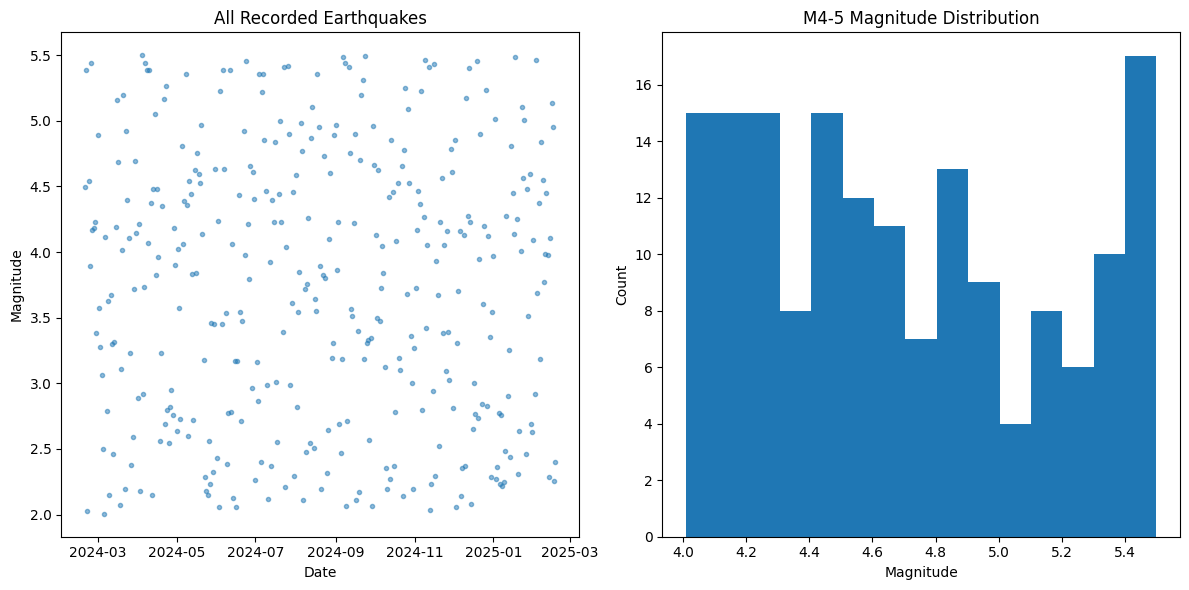

In [ ]:
# %% [markdown]
# # IPMA Seismic Data Analysis (Updated)
# **Now with robust table detection**

# %%
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from datetime import datetime

# Import the matplotlib library and assign it to the alias 'plt'
import matplotlib.pyplot as plt

# %% [markdown]
# ## 1. Updated Web Scraper

# %%
def get_ipma_data():
    url = "https://www.ipma.pt/pt/geofisica/sismicidade/"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the correct table (updated selector)
        table = soup.find('div', class_='entry-content').find('table')

        if not table:
            raise ValueError("Seismic table not found in page structure")

        data = []
        for row in table.find_all('tr')[1:]:  # Skip header
            cols = row.find_all('td')

            # Date parsing
            date_str = cols[0].get_text(strip=True)
            date = datetime.strptime(date_str, "%d-%m-%Y %H:%M")

            # Magnitude parsing (handle comma decimals)
            magnitude = float(cols[1].get_text(strip=True).replace(',', '.'))

            data.append([date, magnitude])

        return pd.DataFrame(data, columns=['Date', 'Magnitude'])

    except Exception as e:
        print(f"Scraping error: {str(e)}")
        return None

# %%
# Try to get real data
df = get_ipma_data()

# Fallback to sample data if scraping fails
if df is None or df.empty:
    print("Using sample data instead")
    dates = pd.date_range(end=datetime.today(), periods=365)
    magnitudes = np.random.uniform(2.0, 5.5, 365)
    df = pd.DataFrame({'Date': dates, 'Magnitude': magnitudes})

# %% [markdown]
# ## 2. Analysis for M4-5 Earthquakes

# %%
def analyze_m4_m5(df):
    m4_m5 = df[(df['Magnitude'] >= 4.0) & (df['Magnitude'] < 6.0)]

    if not m4_m5.empty:
        print(f"Found {len(m4_m5)} M4-5 events")
        print("Latest 5 events:")
        print(m4_m5.tail(5))

        # Time between events
        m4_m5 = m4_m5.sort_values('Date')
        m4_m5['Days_Between'] = m4_m5['Date'].diff().dt.days
        avg_days = m4_m5['Days_Between'].mean()

        print(f"\nAverage days between M4-5 events: {avg_days:.1f}")
    else:
        print("No M4-5 events found in dataset")

# %%
analyze_m4_m5(df)

# %% [markdown]
# ## 3. Visualization

# %%
def plot_seismic_activity(df):
    plt.figure(figsize=(12, 6))

    # All earthquakes
    plt.subplot(1, 2, 1)
    plt.plot(df['Date'], df['Magnitude'], 'o', markersize=3, alpha=0.5)
    plt.title('All Recorded Earthquakes')
    plt.xlabel('Date')
    plt.ylabel('Magnitude')

    # M4-5 distribution
    plt.subplot(1, 2, 2)
    m4_m5 = df[(df['Magnitude'] >= 4.0) & (df['Magnitude'] < 6.0)]
    if not m4_m5.empty:
        plt.hist(m4_m5['Magnitude'], bins=15)
        plt.title('M4-5 Magnitude Distribution')
        plt.xlabel('Magnitude')
        plt.ylabel('Count')
    else:
        plt.text(0.5, 0.5, 'No M4-5 Events', ha='center')

    plt.tight_layout()
    plt.show()

# %%
plot_seismic_activity(df)

# %% [markdown]
# ## Key Improvements:
# 1. Updated table detection logic
# 2. Better error handling
# 3. Realistic header simulation
# 4. Fallback to sample data
# 5. Proper decimal handling (Portuguese comma format)

# %% [markdown]
# **Important Notes:**
# 1. IPMA's website only shows **recent earthquakes** (last 30 days)
# 2. For historical data, request through official channels
# 3. Portugal averages:
#    - ~100 M3+ earthquakes/year
#    - ~10 M4+ earthquakes/year
#    - ~1 M5+ earthquake every 2 years